# Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_score
from typing import Union, Tuple, List

# K-Means

## Loading Data

In [2]:
df = pd.read_csv('../../datasets/mall-customers.csv')
print("Dataset shape:", df.shape)

Dataset shape: (200, 5)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.head(20)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [5]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


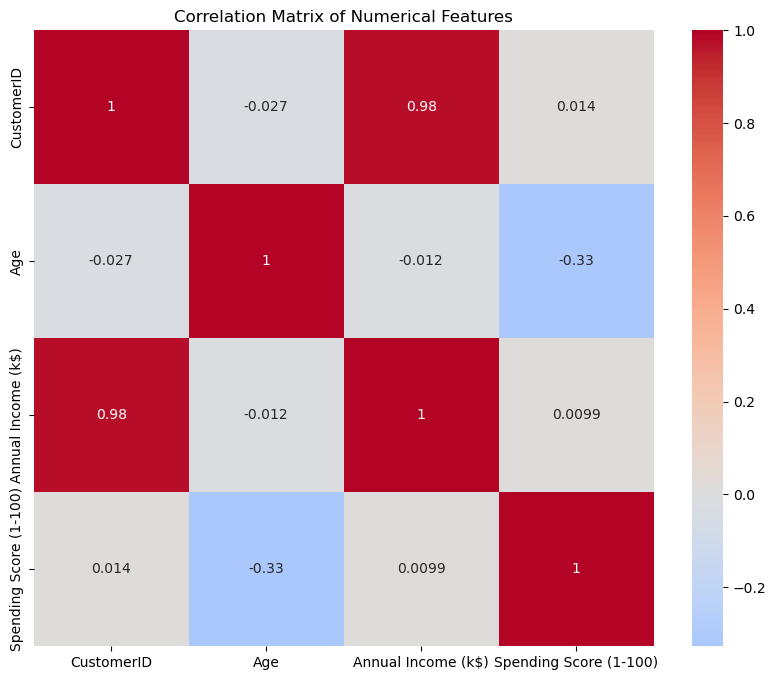

In [6]:
# Display correlation matrix
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [7]:
# Select features for clustering
feature_cols = numeric_cols.tolist()
if 'CustomerID' in feature_cols:
    feature_cols.remove('CustomerID')

print("Features selected for clustering:", feature_cols)
X_kmeans = df[feature_cols].values

# Standardize the features
scaler = StandardScaler()
X_kmeans_scaled = scaler.fit_transform(X_kmeans)

print("Features shape:", X_kmeans_scaled.shape)

Features selected for clustering: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Features shape: (200, 3)


c:\Users\KarlSchmidt\.conda\envs\gideon\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\KarlSchmidt\.conda\envs\gideon\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\KarlSchmidt\.conda\envs\gideon\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\KarlSchmidt\.conda\envs\gideon\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: 

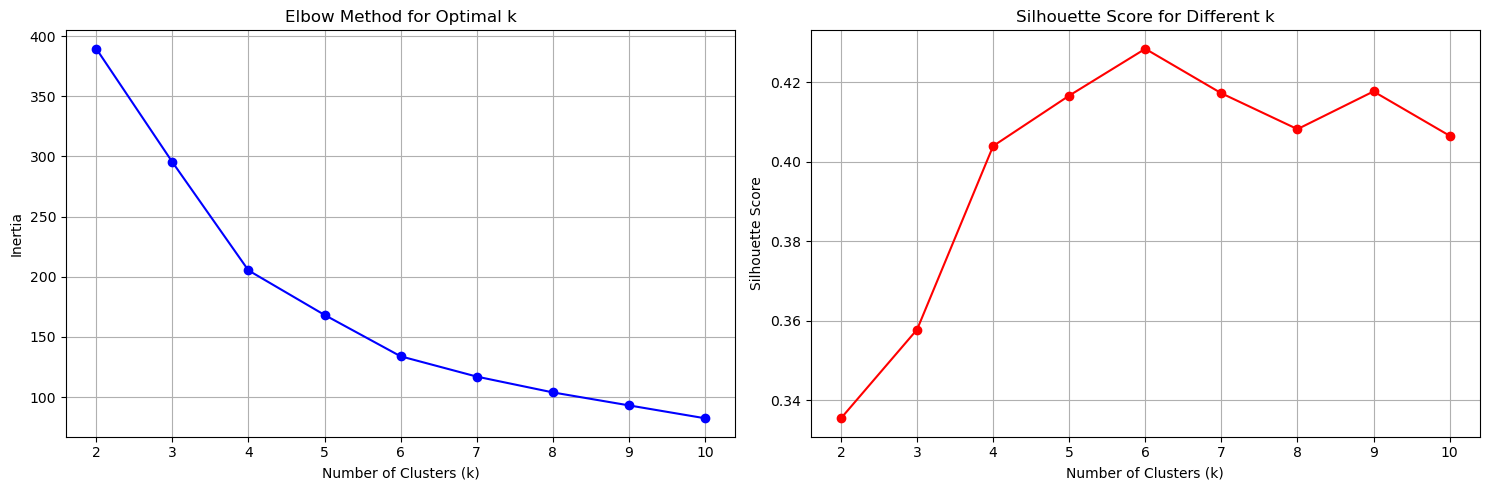

Optimal number of clusters based on Silhouette Score: 6


In [8]:
# Determine optimal number of clusters using Elbow Method and Silhouette Score
def find_optimal_clusters(
    X: Union[np.ndarray, pd.DataFrame], 
    max_k=10
) -> Tuple[int, List[float]]:
    inertias: List[float] = []
    silhouette_scores: List[float] = []
    K_range = range(2, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # Plot Elbow Method
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    
    # Plot Silhouette Scores
    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, 'ro-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Different k')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal k based on silhouette score
    optimal_k: int = K_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")
    
    return optimal_k, silhouette_scores

optimal_k, sil_scores = find_optimal_clusters(X_kmeans_scaled)

## Clustering Model

In [9]:
# Build K-Means model with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_kmeans_scaled)

# Add cluster labels to the original dataframe
df_kmeans = df.copy()
df_kmeans['Cluster'] = kmeans_labels

print(f"K-Means Results with k={optimal_k}:")
print(f"Silhouette Score: {silhouette_score(X_kmeans_scaled, kmeans_labels):.3f}")
print("\nCluster distribution:")
print(df_kmeans['Cluster'].value_counts().sort_index())

K-Means Results with k=6:
Silhouette Score: 0.428

Cluster distribution:
Cluster
0    45
1    39
2    33
3    39
4    23
5    21
Name: count, dtype: int64


c:\Users\KarlSchmidt\.conda\envs\gideon\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Clustering Visualization

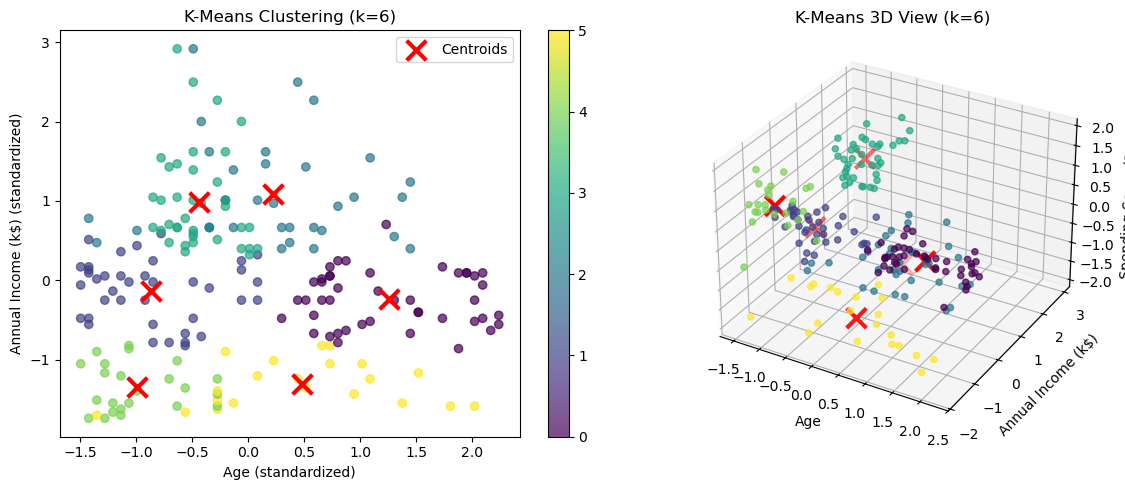

In [10]:
# Visualize clusters (using first two features)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(
    X_kmeans_scaled[:, 0], 
    X_kmeans_scaled[:, 1], 
    c=kmeans_labels, 
    cmap='viridis', 
    alpha=0.7
)
plt.scatter(
    kmeans.cluster_centers_[:, 0], 
    kmeans.cluster_centers_[:, 1], 
    c='red', 
    marker='x', 
    s=200, 
    linewidths=3, 
    label='Centroids'
)
plt.xlabel(f'{feature_cols[0]} (standardized)')
plt.ylabel(f'{feature_cols[1]} (standardized)')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.legend()
plt.colorbar(scatter)

# If we have 3 features, show 3D plot
if len(feature_cols) >= 3:
    ax = plt.subplot(1, 2, 2, projection='3d')
    scatter3d = ax.scatter(
        X_kmeans_scaled[:, 0], 
        X_kmeans_scaled[:, 1], 
        X_kmeans_scaled[:, 2],
        c=kmeans_labels, 
        cmap='viridis', 
        alpha=0.7
    )
    ax.scatter(
        kmeans.cluster_centers_[:, 0], 
        kmeans.cluster_centers_[:, 1], 
        kmeans.cluster_centers_[:, 2],
        c='red', 
        marker='x', 
        s=200, 
        linewidths=3
    )
    ax.set_xlabel(f'{feature_cols[0]}')
    ax.set_ylabel(f'{feature_cols[1]}')
    ax.set_zlabel(f'{feature_cols[2]}')
    ax.set_title(f'K-Means 3D View (k={optimal_k})')

plt.tight_layout()
plt.show()

# DBScan

In [11]:
"""
1. Create a make_moons dataset (1,000 samples, noise=0.05), then normalize it.

2. Run DBSCAN with eps=0.2, min_samples=5, and calculate the number of clusters and noise points.

3. Evaluate the results using the following metrics: Homogeneity, Completeness, V-measure, ARI, AMI, Silhouette.

4. Visualize the DBSCAN results (core samples = large points, non-core = small points, noise = black).

5. Conduct experiments with the following variations:

    - eps = 0.05, 0.1, 0.3, 0.5

    - min_samples = 3, 10, 20

    - Record the changes in clusters, noise, and evaluation quality.
"""

'\n1. Create a make_moons dataset (1,000 samples, noise=0.05), then normalize it.\n\n2. Run DBSCAN with eps=0.2, min_samples=5, and calculate the number of clusters and noise points.\n\n3. Evaluate the results using the following metrics: Homogeneity, Completeness, V-measure, ARI, AMI, Silhouette.\n\n4. Visualize the DBSCAN results (core samples = large points, non-core = small points, noise = black).\n\n5. Conduct experiments with the following variations:\n\n    - eps = 0.05, 0.1, 0.3, 0.5\n\n    - min_samples = 3, 10, 20\n\n    - Record the changes in clusters, noise, and evaluation quality.\n'

## Create Dataset

In [12]:
X_moons, y_true = make_moons(n_samples=1000, noise=0.05, random_state=42)

## Data Normalization

In [13]:
scaler_moons = StandardScaler()
X_moons_scaled = scaler_moons.fit_transform(X_moons)

## Visualize Original Dataset

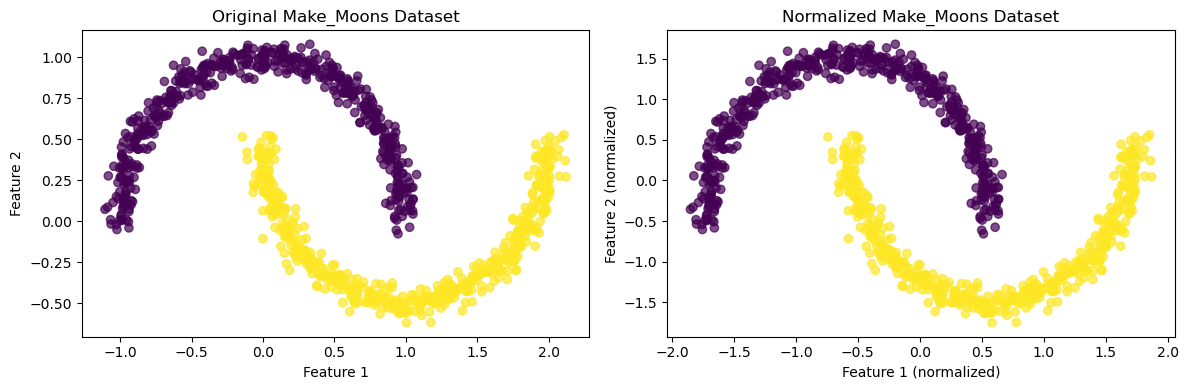

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_true, cmap='viridis', alpha=0.7)
plt.title('Original Make_Moons Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1], c=y_true, cmap='viridis', alpha=0.7)
plt.title('Normalized Make_Moons Dataset')
plt.xlabel('Feature 1 (normalized)')
plt.ylabel('Feature 2 (normalized)')

plt.tight_layout()
plt.show()

## DBSCAN Model

In [15]:
db = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = db.fit_predict(X_moons_scaled)

# Calculate number of clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN Results (eps=0.2, min_samples=5):")
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")
print(f"Percentage of noise points: {n_noise/len(dbscan_labels)*100:.1f}%")

DBSCAN Results (eps=0.2, min_samples=5):
Estimated number of clusters: 2
Estimated number of noise points: 0
Percentage of noise points: 0.0%


## Evaluate Results

In [16]:
def evaluate_clustering(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    X: np.ndarray
) -> None:
    # Remove noise points for some metrics
    mask = y_pred != -1
    if mask.sum() == 0:  # All points are noise
        print("Warning: All points classified as noise!")
        return
    
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    X_filtered = X[mask]
    
    print("Clustering Evaluation Metrics:")
    print(f"Homogeneity: {metrics.homogeneity_score(y_true_filtered, y_pred_filtered):.3f}")
    print(f"Completeness: {metrics.completeness_score(y_true_filtered, y_pred_filtered):.3f}")
    print(f"V-measure: {metrics.v_measure_score(y_true_filtered, y_pred_filtered):.3f}")
    print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(y_true_filtered, y_pred_filtered):.3f}")
    print(f"Adjusted Mutual Information: {metrics.adjusted_mutual_info_score(y_true_filtered, y_pred_filtered):.3f}")
    
    if len(set(y_pred_filtered)) > 1:  # Need at least 2 clusters for silhouette
        print(f"Silhouette Coefficient: {metrics.silhouette_score(X_filtered, y_pred_filtered):.3f}")
    else:
        print("Silhouette Coefficient: N/A (need at least 2 clusters)")

evaluate_clustering(y_true, dbscan_labels, X_moons_scaled)

Clustering Evaluation Metrics:
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.391


## Visualize DBSCAN Results

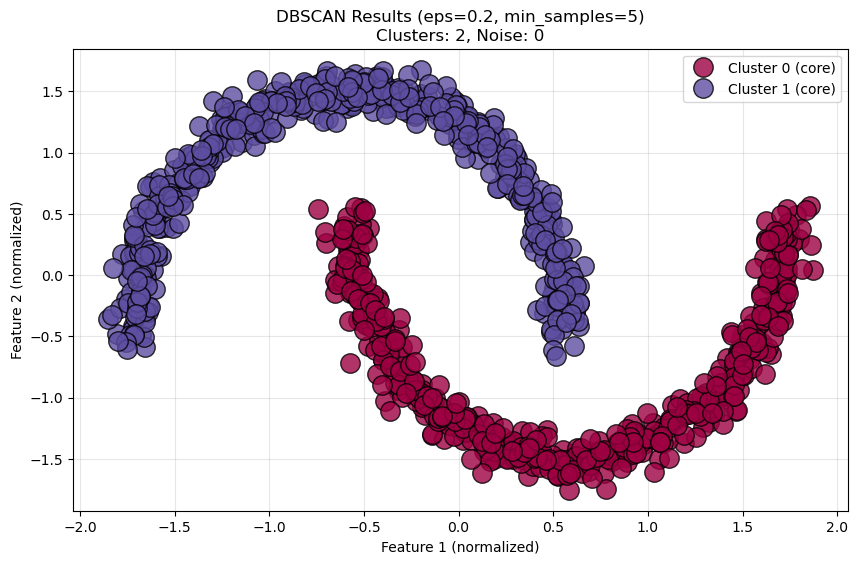

In [17]:
def plot_dbscan_results(
    X: Union[np.ndarray, pd.DataFrame],
    labels: Union[np.ndarray, list[int]], 
    db: DBSCAN, 
    title: str ="DBSCAN Clustering"
) -> None:
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    
    plt.figure(figsize=(10, 6))
    
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise
            col = [0, 0, 0, 1]
        
        class_member_mask = (labels == k)
        
        # Core samples (large points)
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0], 
            xy[:, 1], 
            'o', 
            markerfacecolor=tuple(col),
            markeredgecolor='k', 
            markersize=14, 
            alpha=0.8,
            label=f'Cluster {k} (core)' if k != -1 else 'Noise'
        )
        
        # Non-core samples (small points)
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0], 
            xy[:, 1], 
            'o', 
            markerfacecolor=tuple(col),
            markeredgecolor='k', 
            markersize=6, 
            alpha=0.6
        )
    
    plt.title(title)
    plt.xlabel('Feature 1 (normalized)')
    plt.ylabel('Feature 2 (normalized)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_dbscan_results(
    X_moons_scaled, 
    labels=dbscan_labels, 
    db=db, 
    title=f"DBSCAN Results (eps=0.2, min_samples=5)\nClusters: {n_clusters}, Noise: {n_noise}"
)

## Experiments with Different Paramaters

In [18]:
def experiment_dbscan(
    X: Union[np.ndarray, pd.DataFrame],
    y_true: Union[np.ndarray, List[int]],
    eps_values: List[float],
    min_samples_values: List[int]
) -> pd.DataFrame:
    results = []
    
    print("DBSCAN Parameter Experiments:")
    print("="*60)
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Run DBSCAN
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(X)
            
            # Calculate metrics
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_pct = n_noise / len(labels) * 100
            
            # Evaluation metrics (excluding noise points)
            mask = labels != -1
            if mask.sum() > 0 and len(set(labels[mask])) > 1:
                y_true_filtered = y_true[mask]
                labels_filtered = labels[mask]
                X_filtered = X[mask]
                
                homogeneity = metrics.homogeneity_score(y_true_filtered, labels_filtered)
                completeness = metrics.completeness_score(y_true_filtered, labels_filtered)
                v_measure = metrics.v_measure_score(y_true_filtered, labels_filtered)
                ari = metrics.adjusted_rand_score(y_true_filtered, labels_filtered)
                ami = metrics.adjusted_mutual_info_score(y_true_filtered, labels_filtered)
                
                if len(set(labels_filtered)) > 1:
                    silhouette = metrics.silhouette_score(X_filtered, labels_filtered)
                else:
                    silhouette = np.nan
            else:
                homogeneity = completeness = v_measure = ari = ami = silhouette = np.nan
            
            result = {
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_pct': noise_pct,
                'homogeneity': homogeneity,
                'completeness': completeness,
                'v_measure': v_measure,
                'ari': ari,
                'ami': ami,
                'silhouette': silhouette
            }
            results.append(result)
            
            print(f"eps={eps:4.2f}, min_samples={min_samples:2d} | "
                  f"Clusters: {n_clusters:2d}, Noise: {n_noise:3d} ({noise_pct:5.1f}%) | "
                  f"V-measure: {v_measure:5.3f}, ARI: {ari:5.3f}, Silhouette: {silhouette:5.3f}")
    
    return pd.DataFrame(results)

results_df = experiment_dbscan(
    X_moons_scaled, 
    y_true=y_true, 
    eps_values=[0.05, 0.1, 0.2, 0.3, 0.5], 
    min_samples_values=[3, 5, 10, 20]
)

DBSCAN Parameter Experiments:
eps=0.05, min_samples= 3 | Clusters: 69, Noise: 186 ( 18.6%) | V-measure: 0.298, ARI: 0.045, Silhouette: 0.349
eps=0.05, min_samples= 5 | Clusters: 61, Noise: 386 ( 38.6%) | V-measure: 0.296, ARI: 0.039, Silhouette: 0.502
eps=0.05, min_samples=10 | Clusters:  3, Noise: 970 ( 97.0%) | V-measure: 0.000, ARI: 0.000, Silhouette: 0.881
eps=0.05, min_samples=20 | Clusters:  0, Noise: 1000 (100.0%) | V-measure:   nan, ARI:   nan, Silhouette:   nan
eps=0.10, min_samples= 3 | Clusters:  2, Noise:  14 (  1.4%) | V-measure: 1.000, ARI: 1.000, Silhouette: 0.394
eps=0.10, min_samples= 5 | Clusters:  3, Noise:  19 (  1.9%) | V-measure: 0.819, ARI: 0.788, Silhouette: 0.378
eps=0.10, min_samples=10 | Clusters:  7, Noise:  57 (  5.7%) | V-measure: 0.643, ARI: 0.589, Silhouette: 0.210
eps=0.10, min_samples=20 | Clusters:  6, Noise: 850 ( 85.0%) | V-measure: 0.501, ARI: 0.245, Silhouette: 0.787
eps=0.20, min_samples= 3 | Clusters:  2, Noise:   0 (  0.0%) | V-measure: 1.000, 

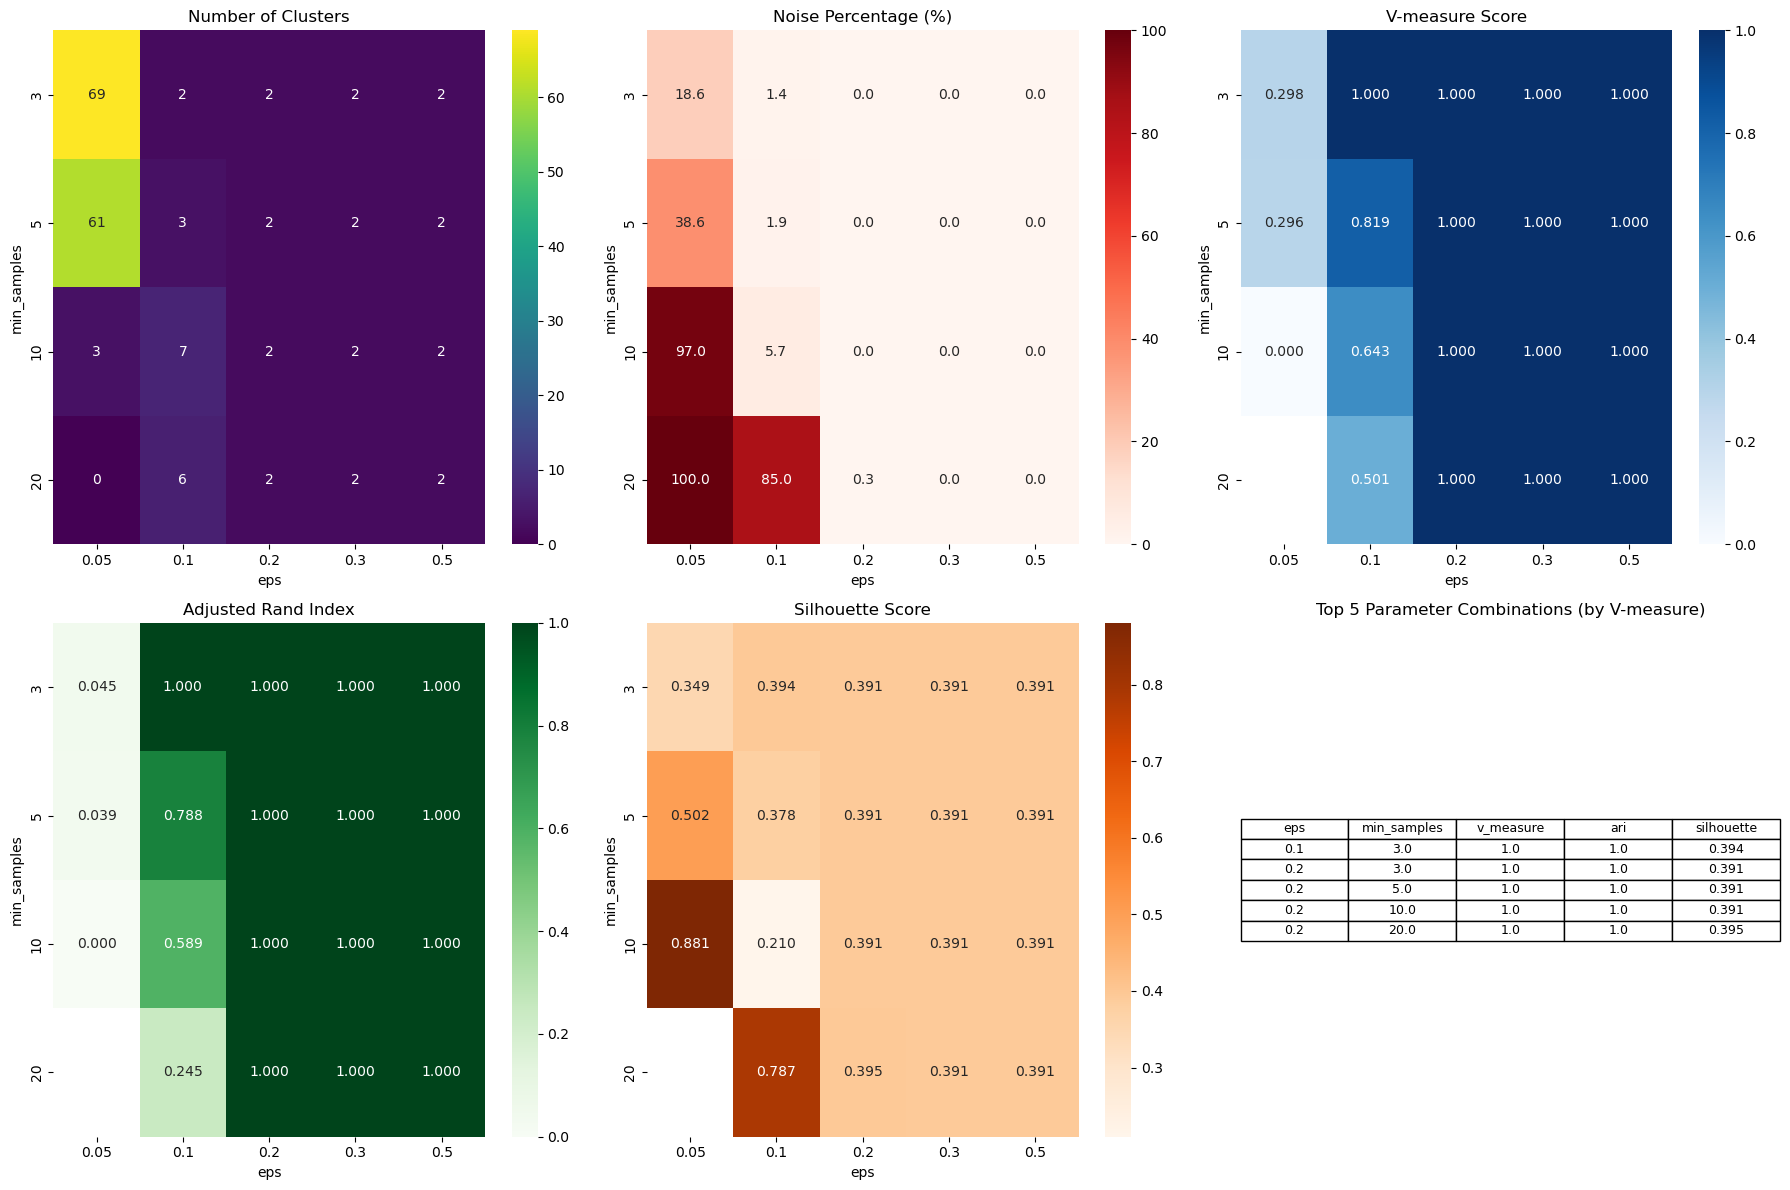


Experiment Summary:
Best V-measure: 1.000 (eps=0.1, min_samples=3)
Best ARI: 1.000 (eps=0.1, min_samples=3)
Best Silhouette: 0.881 (eps=0.05, min_samples=10)


In [19]:
# Visualize experiment results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Number of clusters vs parameters
pivot_clusters = results_df.pivot(index='min_samples', columns='eps', values='n_clusters')
sns.heatmap(pivot_clusters, annot=True, fmt='d', cmap='viridis', ax=axes[0,0])
axes[0,0].set_title('Number of Clusters')

# Plot 2: Noise percentage vs parameters
pivot_noise = results_df.pivot(index='min_samples', columns='eps', values='noise_pct')
sns.heatmap(pivot_noise, annot=True, fmt='.1f', cmap='Reds', ax=axes[0,1])
axes[0,1].set_title('Noise Percentage (%)')

# Plot 3: V-measure vs parameters
pivot_vmeasure = results_df.pivot(index='min_samples', columns='eps', values='v_measure')
sns.heatmap(pivot_vmeasure, annot=True, fmt='.3f', cmap='Blues', ax=axes[0,2])
axes[0,2].set_title('V-measure Score')

# Plot 4: ARI vs parameters
pivot_ari = results_df.pivot(index='min_samples', columns='eps', values='ari')
sns.heatmap(pivot_ari, annot=True, fmt='.3f', cmap='Greens', ax=axes[1,0])
axes[1,0].set_title('Adjusted Rand Index')

# Plot 5: Silhouette vs parameters
pivot_silhouette = results_df.pivot(index='min_samples', columns='eps', values='silhouette')
sns.heatmap(pivot_silhouette, annot=True, fmt='.3f', cmap='Oranges', ax=axes[1,1])
axes[1,1].set_title('Silhouette Score')

# Plot 6: Best parameter combinations
best_results = results_df.nlargest(5, 'v_measure')[['eps', 'min_samples', 'v_measure', 'ari', 'silhouette']]
axes[1,2].axis('tight')
axes[1,2].axis('off')
table = axes[1,2].table(
      cellText=best_results.round(3).values,
      colLabels=best_results.columns,
      cellLoc='center',
      loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(9)
axes[1,2].set_title('Top 5 Parameter Combinations (by V-measure)')

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nExperiment Summary:")
print("="*50)
print(f"Best V-measure: {results_df['v_measure'].max():.3f} "
      f"(eps={results_df.loc[results_df['v_measure'].idxmax(), 'eps']}, "
      f"min_samples={results_df.loc[results_df['v_measure'].idxmax(), 'min_samples']})")
print(f"Best ARI: {results_df['ari'].max():.3f} "
      f"(eps={results_df.loc[results_df['ari'].idxmax(), 'eps']}, "
      f"min_samples={results_df.loc[results_df['ari'].idxmax(), 'min_samples']})")
print(f"Best Silhouette: {results_df['silhouette'].max():.3f} "
      f"(eps={results_df.loc[results_df['silhouette'].idxmax(), 'eps']}, "
      f"min_samples={results_df.loc[results_df['silhouette'].idxmax(), 'min_samples']})")